***최초 작성일 : 22.08.30***<br>

***최종 작성일 : 22.09.19***

# Interactive Porto Insights - A Plot.ly Tutorial

##### "이유한님의 캐글 코리아 캐글 스터디 커널 커리큘럼"에 따라 필사한 내용입니다.

- 필사 노트북의 원 출처 : https://www.kaggle.com/code/arthurtok/interactive-porto-insights-a-plot-ly-tutorial/notebook

-----

## Introduction

이 대회는 브라질의 Porto Seguro에서 주최한 대회로, **운전자가 내년에 보험금을 청구를 시작할 확률을 예측**한다.

이 노트는 **파이썬 시각화 라이브러리인 Plot.ly를 통해 대회 데이터를 interactive 차트와 분석 결과를 제공하며 다른 사람이 참고할 수 있을만한 인사이트와 표를 제공하는 것을 목표**로 한다. Plot.ly는 온라인 그래픽 및 통계 시각화(차트와 대시보드)를 제공하는 소프트웨어 회사 Plotly가 제공하는 패키지 중 하나로 Python, R, Matlab, Node.js 등 다양한 언어에 API로 제공한다.

이 노트에서 사용한 Plotly 그래프는 아래와 같다.<br>
**Simple horizontal bar plot** - 출력 값의 데이터 분포를 보는데 사용<br>
**Correlation Heatmap plot** - 변수들 간의 상관 관계 표현<br>
**Scatter plot** - Random Forest 모델과 Gradient-Boost 모델에서 생성된 feature importance 비교<br>
**Vertical bar plot** - 다양한 변수의 중요도를 내림차순 정렬<br>
**3D Scatter plot**<br>

이 노트의 주제는 아래와 같이 요약할 수 있다.<br>

1. Data Quality 체크 : 결측값/Null 값 시각화 및 평가

2. Feature 검토 및 필터링 : 타겟 변수에 대한 상관 관계 및 시각화, 변수 타입에 따른 검토

3. 학습 모델을 통한 feature importance 순위 지정 : Random Forest 모델 및 Gradient-Boost 모델을 학습한 후 feature importance 순위 시각화


--------

In [1]:
# Let us load in the relvent Python modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('./dataset/porto-seguro/train.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
# Taking a look at how many rows and columns the train dataset contains
rows = train.shape[0]
columns = train.shape[1]

print('The train dataset contain {0} rows and {1} columns'.format(rows, columns))

The train dataset contain 595212 rows and 59 columns


## 1. Data Quality checks<br>

**Null and missing value checks**<br>

학습 데이터에 null 값이 존재하는지 확인한다.

In [4]:
# any() applied twice to check run the isnull check across all columns.
train.isnull().any().any()

False

- Null 값을 확인하였을 때 False를 반환하지만 데이터가 이 대회의 데이터는 -1인 경우 feature가 누락되었음을 표현하기 때문에 Null 처리가 된 것은 아니다.

-1 값을 Null로 바꾼 후 Null을 확인해보자.

In [5]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

<AxesSubplot:>

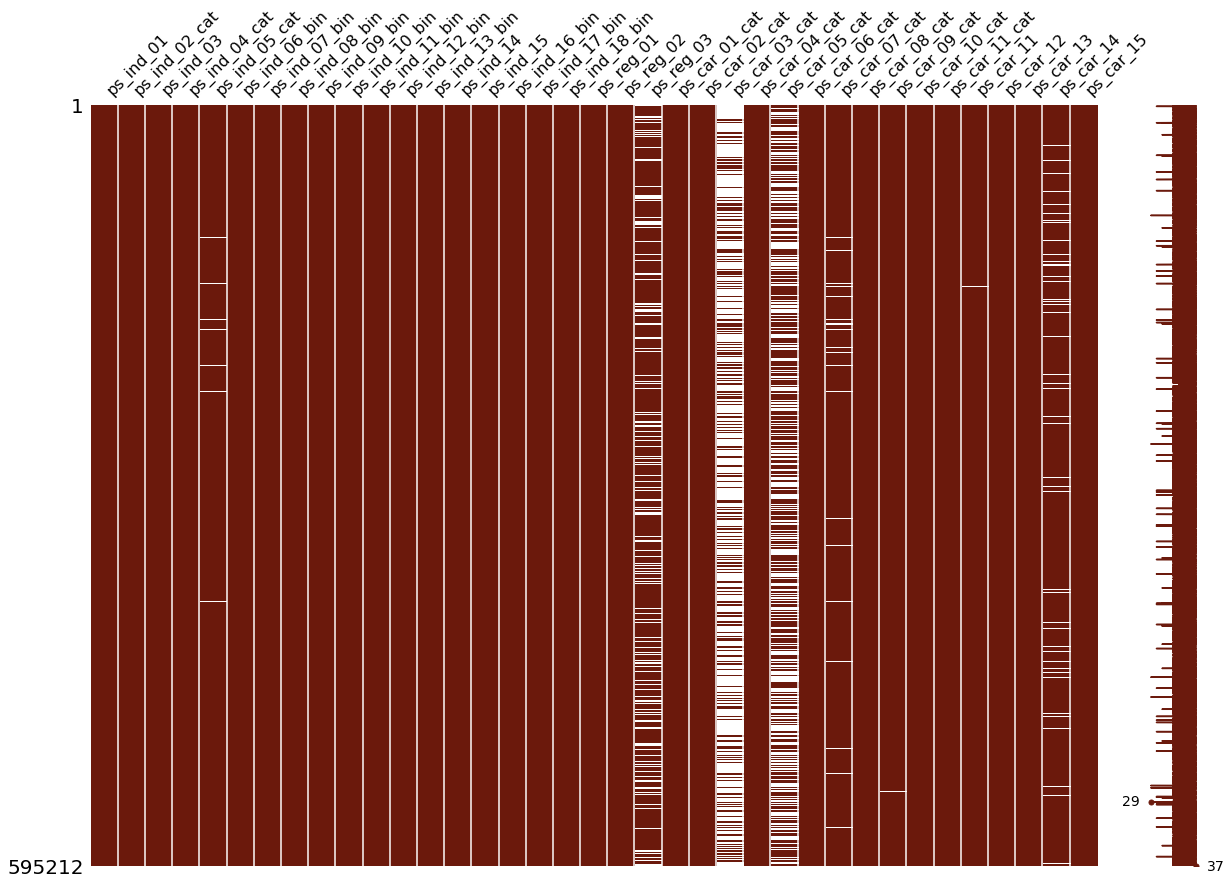

In [6]:
import missingno as msno

# Nullity or missing values by columns
msno.matrix(df = train_copy.iloc[:, 2:39], figsize = (20, 14), color = (0.42, 0.1, 0.05))

위 차트에서 볼 수 있듯이, 결측값은 시각화를 할 때 분명해진다.<br>
각 변수들은 수직 막대 그래프 형태로 표현되어있는데 중간에 빈 흰색 부분은 결측 값을 표현한다. 위 차트의 경우 59개의 변수 중 7개의 변수가 결측 값이 존재한다.<br>

결측 값이 존재하는 7개의 변수는 아래와 같다.<br>
ps_ind_05_cat | ps_reg_03 | ps_car_03_cat | ps_car_05_cat | ps_car_07_cat | ps_car_09_cat | ps_car_14<br>

결측 값은 대부분 "_cat" 으로 접미사가 붙은 열에 발생한다.<br>
특히 ps_reg_03, ps_car_03_cat, ps_car_05_cat 열은 더 많은 결측 값이 있기 때문에 모든 결측 값에 대해 다른 값으로 대체하는 선택은 그다지 좋은 선택이 아닐 수 있다.


#### Target variable inspection

데이터를 살펴볼 때 일반적으로 목표 변수에 관해 살펴보아야 한다. 목표 변수는 클래스(class)/라벨(label) 등으로도 말한다.<br>

In [9]:
data = [go.Bar(
            x = train['target'].value_counts().index.values,
            y = train['target'].value_counts().values,
            text = 'Distribution of target variable'
        )]

layout = go.Layout(
        title = 'Target variable distribution'
)

fig = go.Figure(data = data, layout = layout)

py.iplot(fig, filename = 'basic-bar')

목표 변수가 불균형이 심하기 때문에 분석 시에 유의해야 한다.

#### Datatype check

이 파트는 학습 데이터가 어떤 타입의 데이터로 구성되어 있는지 확인한다.<br>
Python에서 **Collections** 패키지에서 Counter 함수를 사용하면 아래와 같이 데이터 타입에 따른 변수의 개수를 알려준다.

In [8]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

이전에 언급한 바와 같이 학습 데이터 셋의 변수는 총 59개이며 위 결과를 통해 알 수 있듯이 정수형과 실수형 데이터로 구성된다.<br>

Porto Seguro 데이터는 "_bin", "_cat", "_reg"와 같은 약어로 접미사가 붙은 데이터를 제공하였는데, 여기서 bin은 이진 데이터 형태로 표현된 변수를 의미하고, cat은 범주형 변수, 나머지는 연속형 또는 순서형 변수를 나타낸다.<br>

In [9]:
train_float = train.select_dtypes(include = ['float64'])
train_int = train.select_dtypes(include = ['int64'])

### Correlation plots

우선, 변수가 선형적으로 어떤 상관관계가 있는지 가난히 살펴보자.<br>
여기서 seaborn 통계 시각화 패키지를 사용하여 상관관계를 표현하는 표를 그릴 것이다. Pandas에는 Pearson 상관관계를 계산할 수 있는 corr() 함수가 내정되어 있다.

#### Correlation of float features

<AxesSubplot:title={'center':'Pearson correlation of continuous features'}>

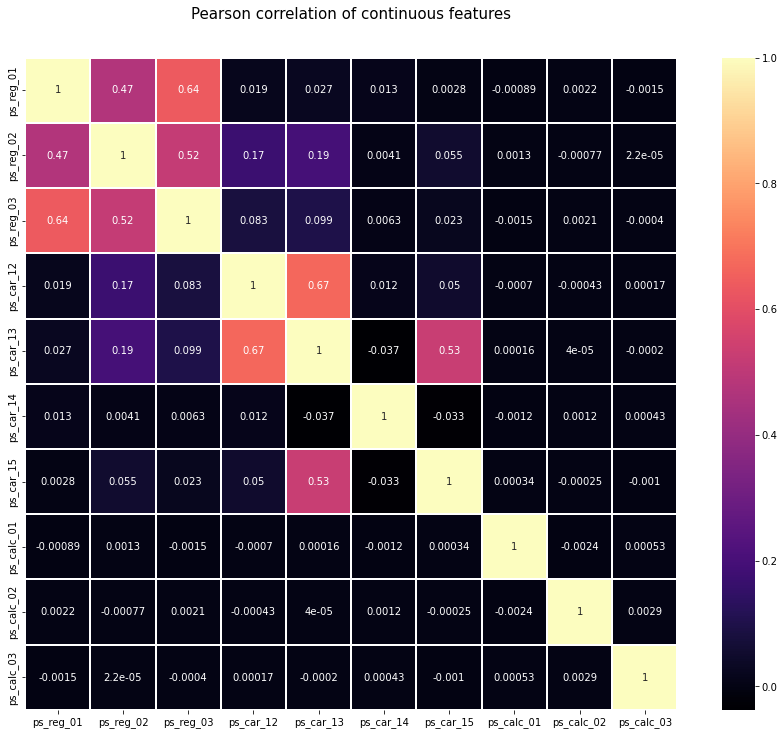

In [10]:
colormap = plt.cm.magma
plt.figure(figsize = (16, 12))
plt.title('Pearson correlation of continuous features', y = 1.05, size = 15)
sns.heatmap(train_float.corr(), linewidths = 0.1, vmax = 1.0, square = True,
            cmap = colormap, linecolor = 'white', annot = True)

대부분의 변수는 상관관계가 거의 존재하지 않지만 아래의 변수들은 상관 관계가 존재하는 것을 알 수 있다.

**(ps_reg_01, ps_reg_03)<br>
(ps_reg_02, ps_reg_03)<br>
(ps_car_12, ps_car_13)<br>
(ps_car_13, ps_car_15)**<br>

#### Correlation of integer features

아래 코드는 정수 데이터 유형의 열에 대해서 Plotly 라이브러리를 사용하여 상호 작용이 되는 히트맵 그래프를 생성하는 예시를 보여준다.<br>
Plotly에서는 go 객체를 통해 히트맵 객체를 생성한다. x축, y축은 열 이름을 z축은 상관계수를 대입해야한다.<br>
colorscale의 경우 키워드를 통해 다양한 색상을 불러올 수 있는데 여기서는 Viridis를 사용했다.

In [11]:
# train_int = train_int.drop(['id', 'target'], axis = 1)
# colormap = plt.cm.bone
# plt.figure(figsize = (21, 16))
# plt.title('Pearson corraltion of categorical features', y = 1.05, size = 15)
# sns.heatmap(train_cat.corr(), linewidth = 0.1, vmax = 1.0, square = True,
#             cmap = colormap, linecolor = 'white', annot = False)

data = [
    go.Heatmap(
        z = train_int.corr().values,
        x = train_int.columns.values,
        y = train_int.columns.values,
        colorscale = 'Viridis',
        reversescale = False,
#         text = True,
        opacity = 1.0)
]

layout = go.Layout(
    title = 'Pearson Correlation of Integer-type features',
    xaxis = dict(ticks = '', nticks = 36),
    yaxis = dict(ticks = ''),
    width = 900, height = 700)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'labelled-heatmap')

마찬가지로, 상관계수가 0에 근사한 셀들이 꽤 많은 것을 볼 수 있는데, 선형적 관계가 없는 열이 많다는 것을 알 수 있다.<br>
주성분 분석(PCA)과 같이 차원 축소를 할 때 어느 정도 상관관계가 필요한데 위와 같이 먼저 선형관계를 살펴본 후에 적용할 수 있겠다.<br>

### Mutual Information plots

Mutual information은 목표 변수와 상응하는 변수 사이의 상호 정보(?)를 계산할 수 있는 도구이다.<br>
분류 문제의 경우, Sklearn의 mutual_info_classif 함수를 사용하여 두 랜덤 변수 사이의 의존성을 측성하고 그 범위는 0부터 높은 값까지 측정할 수 있다.<br>

**Q. 여기서 말하는 Mutual information이라는 정의를 정확히 모르겠다. (20220918)**

mutual_info_classif 함수는 "k-근접 이웃 방법의 엔트로피 추정에 기반한 비모수 방법에 의존"한다고 하며 자세한 내용은 [링크](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif)를 통해 알수 있다.


In [12]:
mf = mutual_info_classif(train_float.values, train.target.values, n_neighbors = 3, random_state = 17)
print(mf)

[0.01402035 0.00431986 0.0055185  0.00778454 0.00157233 0.00197537
 0.01226    0.00553038 0.00545101 0.00562139]


### Binary featrues inspection

이진 값으로 이루어진 변수는 아래와 같이 수직 막대 스래프로 표현할 수 있다.

In [13]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []

for col in bin_col:
    zero_list.append((train[col] == 0).sum())
    one_list.append((train[col] == 1).sum())

In [14]:
trace1 = go.Bar(
    x = bin_col,
    y = zero_list,
    name = 'Zero count'
)
trace2 = go.Bar(
    x = bin_col,
    y = one_list,
    name = 'One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode = 'stack',
    title = 'Count of 1 and 0 in binary variables'
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'stacked-bar')

위 그래프를 보면 ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin 변수는 0이 대부분이다.<br>
이러한 형태의 변수는 다른 변수에 비해 분류 문제시 분별력이 있는 변수인지 확인해야 한다.

### Categorical and Ordinal feature inspection

### Feature importance via Random Forest

이제 학습 데이터를 Random Forest 방법으로 학습 후 feature importance까지 확인하겠다.

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 150, max_depth = 8, min_samples_leaf = 4, max_features = 0.2,
                            n_jobs = -1, random_state = 0)
rf.fit(train.drop(['id', 'target'], axis = 1), train.target)
features = train.drop(['id', 'target'], axis = 1).columns.values

print('----- Training Done -----')

----- Training Done -----


#### Plot.ly Scatter Plot of feature importances

RF 모델 학습 후 내장 함수로 feature importance를 볼 수 있다. 추출한 feature importance를 plotly 그래프 중 하나인 산점도로 표현할 수 있다.<br>

여기서 산점도의 속성은 marker 파라미터를 통해 조절할 수 있다.

In [16]:
# Scatter plot
trace = go.Scatter(
    y = rf.feature_importances_,
    x = features,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        color = rf.feature_importances_,
#         colorsacle = 'Portland',
        showscale = True
    ),
)

data = [trace]
layout = go.Layout(
    autosize = True,
    title = 'Random Forest Feature Importance',
    hovermode = 'closest',
    xaxis = dict(
        ticklen = 5,
        showgrid = False,
        zeroline = False,
        showline = False
    ),
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        showgrid = False,
        zeroline = False,
        gridwidth = 2
    ),
    showlegend = False
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'scatter2010')

또한 아래와 같이 동일한 방식으로 막대 그래프로 feature importance를 내림차순으로 정렬할 수 있다.

In [17]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), reverse = False)))

trace2 = go.Bar(
    x = x,
    y = y,
    marker = dict(
        color = x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name = 'Random Forest Feature importacne',
    orientation = 'h',
)

layout = dict(
    title = 'Barplot of Feature importance',
    width = 900, height = 2000,
    yaxis = dict(
        showgrid = False,
        showline = False,
        showticklabels = True,
#         domain = [0, 0.85],
    ))

fig1 = go.Figure(data = [trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename = 'plots')

#### Decision Tree visuallisation

결정 트리 모델의 경우 나뭇가지를 시각화하여 어떤 변수에 의해 분류가 되는지 표현할 수 있다.<br>
"export_graphviz"에서 트리 정보를 시각화 후 그에 대한 이미지를 저장 및 불러온다.

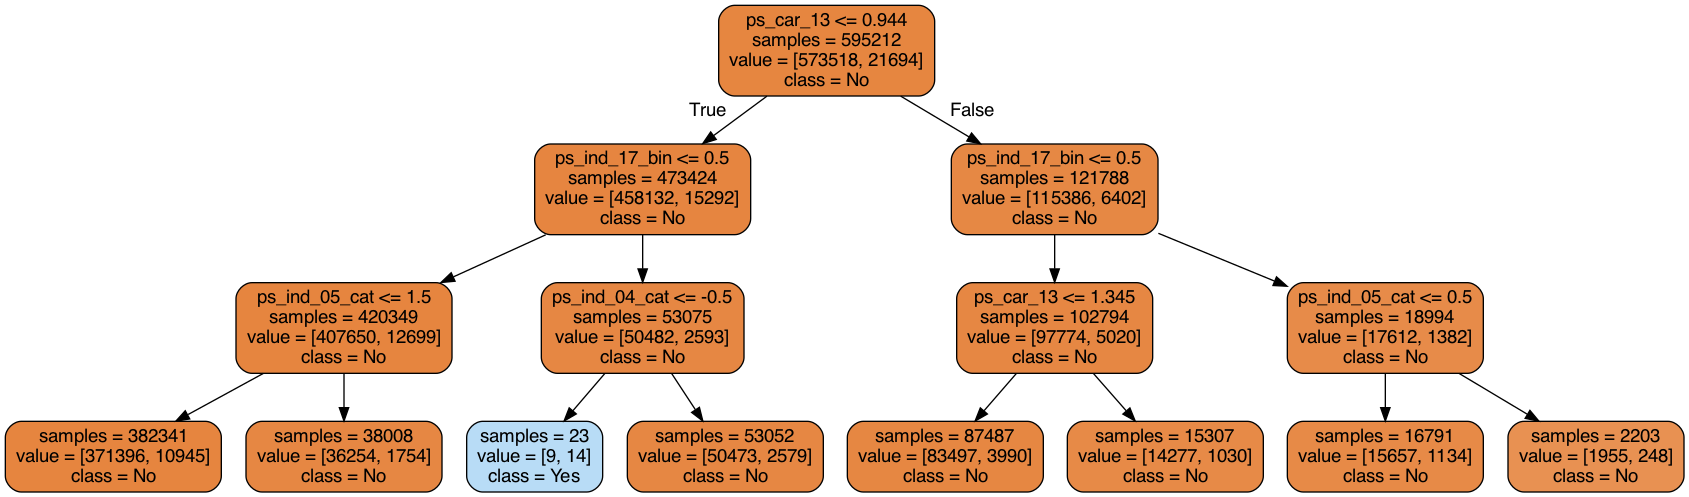

In [18]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(train.drop(['id', 'target'], axis = 1), train.target)

# Export out trained model as a .dot file
with open("tree1.dot", 'w') as f:
    f = tree.export_graphviz(decision_tree,
                             out_file = f,
                             max_depth = 4,
                             impurity = False,
                             feature_names = train.drop(['id', 'target'], axis = 1).columns.values,
                             class_names = ['No', 'Yes'],
                             rounded = True,
                             filled = True
                            )
    
# Convert .dot to .png to allow display in web notebook
check_call(['dot', '-Tpng', 'tree1.dot', '-o', 'tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png",)

### Feature importance via Gradient Boosting model

이번에는 Gradient Boosting 모델을 사용하여 feature importance를 얻겠다.

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators = 100, max_depth = 3, min_samples_leaf = 4,
                                max_features = 0.2, random_state = 0)
gb.fit(train.drop(['id', 'target'], axis = 1), train.target)
features = train.drop(['id', 'target'], axis = 1).columns.values

print("----- Training Done -----")

----- Training Done -----


In [20]:
# Scatter plot
trace = go.Scatter(
    y = gb.feature_importances_,
    x = features,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
#         size = rf.feature_importance_,
#         color = np.random.randn(500), # set color equal to a variable
        color = gb.feature_importances_,
        colorscale = 'Portland',
        showscale = True
    ),
    text = features
)

data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Gradient Boosting Machine Feature Importance',
    hovermode = 'closest',
    xaxis = dict(
        ticklen = 5,
        showgrid = False,
        zeroline = False,
        showline = False,
    ),
    yaxis = dict(
        title = 'Feature Importacne',
        showgrid = False,
        zeroline = False,
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'scatter2010')

In [21]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features),
                                    reverse = False)))

trace2 = go.Bar(
    x = x,
    y = y,
    marker = dict(
        color = x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name = 'Gradient Boosting Classifier Feature importance',
    orientation = 'h',
)

layout = dict(
    title = 'Barplot of Feature importances',
    width = 900, height = 2000,
    yaxis = dict(
        showgrid = False,
        showline = False,
        showticklabels = True,
    ))

fig1 = go.Figure(data = [trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename = 'plots')

흥미로운 것은 RF 모델과 GB 모델 모두 가장 중요한 변수가 ps_car_13이다.

## Conclusion

이 노트는 Porto Seguro 데이터에 대해서 간단한 전처리 과정(Null 값 확인 및 처리, 변수간의 상관계수 확인 등)을 거쳤고<br>
Random Forest, Gradient Boosting 모델을 구현후 feature importance도 확인하였다.

----------

### 1. 데이터셋 설명 

이 노트의 데이터는 변수에 대한 정보를 설명하지 않는다.

### 2. 분석 기법 등 이번 노트에서 쓰인 방법론

이 노트는 Plotly 패키지에 대한 간단한 시각화에 초점을 맞추고 있으며 이에 대한 추가적인 구현은 다른 노트를 추가 생성 후 구현할 예정이다.

------

#### 1. 공부한 내용<br>
 → plotly에 대한 간단한 구현 방법<br>

#### 2. 어려웠던 부분
 → 없음
 
#### 3. 느낀점 및 좋던 부분
 → 음.. 별로 없는 듯.
 
#### 4. 라이브러리 사용법
 → 추가 노트를 생성
 
#### 5. 해당 커널의 특징(다른 커널과의 차별점)
 → 대표적인 시각화 패키지 중 하나인 plotly에 대한 설명 및 간단한 구현이 되어 있다. 근데... 그렇게 많은 내용은 아닌 듯..
 
#### 6. 추후 공부 및 정리할 내용
 → plotly에 대해 추가적으로 정리해야 함.